Step 1: Get data

In [1]:
import pandas as pd

# Load the CSV file
users = pd.read_csv('rating.csv')
animes = pd.read_csv('anime.csv')
print(users.head())
print(animes.head())


   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262 

In [2]:
from sklearn.model_selection import train_test_split
import pickle

In [3]:
# just crop data to be first n
users = users[:500000]
train_users, test_users = train_test_split(users, test_size=0.1)

In [4]:
from collections import defaultdict

# get some useful info from users
allUsers = set()
allAnime = set()
usersPerAnime = defaultdict(set) # Maps an anime to the user who rated it
animePerUser = defaultdict(set) # Maps a user to the anime that they rated
reviewsPerUser = defaultdict(list)
reviewsPerAnime = defaultdict(list)
ratingDict = {} # To retrieve a rating for a specific user/item pair


# item = book in this case
for _, d in users.iterrows():
    user = d['user_id']
    allUsers.add(user)
    anime = d['anime_id']
    allAnime.add(anime)
    usersPerAnime[anime].add(user)
    animePerUser[user].add(anime)
    reviewsPerAnime[anime].append(d)
    reviewsPerUser[user].append(d)
    ratingDict[(user,anime)] = d['rating']


In [5]:
# Compute popularity scores
popularity_dict=defaultdict(float) # score from 0-1 about how popular it is, 1 being the max. 

max_users = max(len(users) for users in usersPerAnime.values()) if usersPerAnime else 1
for anime, users in usersPerAnime.items():
    popularity_dict[anime] = len(users) / max_users  # Normalize popularity score


In [6]:
# print(len(animePerUser))
print(len(popularity_dict))

7145


In [7]:
# # Load from pickle files
# with open('train_users.pkl', 'rb') as f:
#     train_users = pickle.load(f)
# 
# with open('test_users.pkl', 'rb') as f:
#     test_users = pickle.load(f)

In [8]:

print(f"train set : {len(train_users)}, test set people: {len(test_users)}")
print(test_users.head())

train set : 450000, test set people: 50000
        user_id  anime_id  rating
291134     3017     19573       7
256641     2665       164       7
298948     3084      5337       6
75465       783     10110       9
207459     2113      8449       7


In [9]:
# # Save train and test dataframes
# with open('train_users.pkl', 'wb') as f:
#     pickle.dump(train_users, f)
# 
# with open('test_users.pkl', 'wb') as f:
#     pickle.dump(test_users, f)

In [10]:
# what is the rating scale? 
# print('max rating is ', max(train_users['rating'])) # its 10
# print('min rating is ', min(train_users['rating'])) # its -1

Now create baseline model for recommendation

In [11]:
from surprise import Dataset, Reader, SVDpp
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from itertools import combinations
from scipy.spatial.distance import cosine

In [12]:
reader = Reader(rating_scale=(-1, 10))  # Assuming ratings from 1 to 5
train_data = Dataset.load_from_df(train_users, reader)  # Assuming ratings_df is your ratings dataframe
trainset = train_data.build_full_trainset()
test_data = Dataset.load_from_df(test_users, reader)
svdpp = SVDpp(n_factors=3, n_epochs=20, lr_all=0.007, reg_all=0.02, verbose=True)


In [13]:
svdpp.fit(trainset)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


In [14]:
from surprise.model_selection import KFold

kf = KFold(random_state=0)  # folds will be the same for all algorithms.
cross_validate(svdpp, test_data, ["rmse","mae"],kf)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8


{'test_rmse': array([2.62548374, 2.50434062, 2.59274368, 2.56418451, 2.63431042]),
 'test_mae': array([1.78340055, 1.72175223, 1.7771056 , 1.76480119, 1.81518938]),
 'fit_time': (0.372661828994751,
  0.36225104331970215,
  0.37107300758361816,
  0.36126112937927246,
  0.36824989318847656),
 'test_time': (0.1901543140411377,
  0.18239521980285645,
  0.18002104759216309,
  0.18026089668273926,
  0.18445801734924316)}

Now we need to test diversity

In [50]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from itertools import combinations

def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets."""
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

# Global caches for performance
user_similarity_cache = {}
anime_genres = {}
anime_popularity = {}
max_popularity = 1

def initialize_caches(anime_df):
    """Initialize global caches for faster lookups."""
    global anime_genres, anime_popularity, max_popularity
    
    
    print('initializing caches')
    
    # Pre-compute genre sets for each anime
    for i, row in anime_df.iterrows():
        if i %100==0:
            print(f'at no. {i}. {i/len(anime_df)*100}% complete')
        anime_id = int(row['anime_id'])
        genre_str = row.get('genre', '')
        anime_genres[anime_id] = set(genre_str.split(', ')) if pd.notna(genre_str) else set()
    
    # Pre-compute popularity scores
    anime_popularity = {int(row['anime_id']): row.get('members', 0) for _, row in anime_df.iterrows()}
    max_popularity = max(anime_popularity.values()) if anime_popularity else 1

def get_similar_users(user_id, k=10):
    """Find k most similar users with caching."""
    if user_id in user_similarity_cache:
        return user_similarity_cache[user_id][:k]
    
    if user_id not in animePerUser:
        return []
    
    user_watched = animePerUser[user_id]
    similarities = {}

    for other_user, other_watched in animePerUser.items():
        if other_user == user_id:
            continue
        similarities[other_user] = jaccard_similarity(user_watched, other_watched)
    
    result = [uid for uid, _ in sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:k]]
    user_similarity_cache[user_id] = result
    return result

def get_candidate_anime(similar_users):
    """Get anime watched by similar users."""
    if not similar_users:
        return []
    
    candidate_anime = set()
    for user in similar_users:
        if user in animePerUser:
            candidate_anime.update(animePerUser[user])
    
    return list(candidate_anime)

def calculate_diversity(anime_ids, svdpp):
    """Calculate diversity with proper latent factor diversity from SVD++."""
    # Convert all IDs to integers
    anime_ids = [int(aid) for aid in anime_ids]
    
    # Extract genre sets and popularity scores
    genre_sets = [anime_genres.get(aid, set()) for aid in anime_ids]
    popularity_scores = [anime_popularity.get(aid, 0) for aid in anime_ids]
    
    # Calculate genre similarities
    genre_similarities = []
    for i, j in combinations(range(len(genre_sets)), 2):
        if genre_sets[i] or genre_sets[j]:  # Skip empty sets
            genre_similarities.append(jaccard_similarity(genre_sets[i], genre_sets[j]))
    
    # Calculate genre diversity (avoid division by zero)
    genre_diversity = 1 - (sum(genre_similarities) / len(genre_similarities)) if genre_similarities else 1
    
    # Calculate latent diversity using SVD++ item factors
    latent_similarities = []
    for i, j in combinations(range(len(anime_ids)), 2):
        # Convert raw anime IDs to inner IDs used by SVD++
        try:
            inner_id_i = svdpp.trainset.to_inner_iid(anime_ids[i])
            inner_id_j = svdpp.trainset.to_inner_iid(anime_ids[j])
            
            # Get item factors from SVD++ using inner IDs
            item_i_factors = svdpp.qi[inner_id_i]
            item_j_factors = svdpp.qi[inner_id_j]
            
            # Calculate cosine similarity between factor vectors
            sim = cosine_similarity([item_i_factors], [item_j_factors])[0][0]
            latent_similarities.append(sim)
        except ValueError:
            # Handle cases where anime_id isn't in the trainset
            if anime_ids[i] not in svdpp.trainset.all_items():
                print(f"Missing latent factors for anime_id: {anime_ids[i]}")
            if anime_ids[j] not in svdpp.trainset.all_items():
                print(f"Missing latent factors for anime_id: {anime_ids[j]}")
    
    # Calculate latent diversity (avoid division by zero)
    latent_diversity = 1 - (sum(latent_similarities) / (len(latent_similarities) + 1e-8))
    # normalize to be within [0-1]
    latent_diversity = max(0, min(latent_diversity, 1))
    
    
    # Calculate long tail penalty
    avg_popularity = sum(popularity_scores) / (len(popularity_scores) * max_popularity) if popularity_scores and max_popularity > 0 else 0.5
    long_tail_penalty = 1 - avg_popularity
    
    # Weighted combination
    diversity_score = (0.4 * genre_diversity) + (0.4 * latent_diversity) + (0.2 * long_tail_penalty)
    
    return diversity_score, genre_diversity, latent_diversity, long_tail_penalty

def get_predictions_batch(uid, candidate_anime, svdpp):
    """Get predictions for multiple anime IDs at once."""
    return [(iid, svdpp.predict(uid, int(iid)).est) for iid in candidate_anime]

def get_recommendations_with_diversity(test_users, svdpp, anime_df, n=5):
    """Get recommendations with diversity metrics and progress tracking."""
    # Initialize caches if not already done
    if not anime_genres:
        initialize_caches(anime_df)
    
    # Results arrays
    diversity_scores = []
    genre_diversity_scores = []
    latent_diversity_scores = []
    long_tail_penalty_scores = []
    
    # Implementation of predictions list: maps users to recommended anime
    predictions = []
    
    total_users = len(test_users)
    print(f"Processing {total_users} users...")
    
    # Process each user
    for i, (_, u) in enumerate(test_users.iterrows()):
        uid = int(u["user_id"])
        
        # Print progress every 10 users or at key percentages
        if i % 10 == 0 or i / total_users in [0.25, 0.5, 0.75, 0.99]:
            percentage = (i / total_users) * 100
            print(f"Progress: {percentage:.1f}% ({i}/{total_users} users processed)")
        
        # Get similar users and candidate anime
        similar_users = get_similar_users(uid, k=10)
        candidate_anime = get_candidate_anime(similar_users)
        
        if not candidate_anime:
            print(f"User {uid}: No candidate anime found, skipping")
            continue
        
        # Get predictions for candidate anime
        prediction_results = get_predictions_batch(uid, candidate_anime, svdpp)
        
        # Get top N recommendations
        top_n_anime = [iid for iid, _ in sorted(prediction_results, key=lambda x: x[1], reverse=True)[:n]]
        
        # Add to predictions list
        predictions.append({uid: top_n_anime})
        
        # Calculate diversity scores
        scores = calculate_diversity(top_n_anime, svdpp)
        
        # Store results
        diversity_scores.append(scores[0])
        genre_diversity_scores.append(scores[1])
        latent_diversity_scores.append(scores[2])
        long_tail_penalty_scores.append(scores[3])
    
    print(f"Completed processing all {total_users} users")
    
    return diversity_scores, genre_diversity_scores, latent_diversity_scores, long_tail_penalty_scores, predictions

In [31]:
# filter test_users to be unique users. 
test_users = test_users.drop_duplicates(subset="user_id")
print(len(test_users))

4391


In [45]:
# Get all anime IDs that exist in your dataset
all_anime_ids = set(test_users["anime_id"].tolist())

# Get anime IDs that exist in the SVD++ model
# For arrays, we need to check the internal raw_iid mapping
model_anime_ids = set(svdpp.trainset._raw2inner_id_items.keys())

# Find missing anime IDs
missing_anime = list(all_anime_ids - model_anime_ids)
print(f"Missing anime no.: {len(missing_anime)}")

Missing anime no.: 8292


In [51]:
# Run recommendations and calculate diversity score
agg_score, genre_score, latent_score, penalty_score, predictions = get_recommendations_with_diversity(test_users[:100], svdpp, animes, n=5)

initializing caches
at no. 0. 0.0% complete
at no. 100. 0.8134049129656743% complete
at no. 200. 1.6268098259313486% complete
at no. 300. 2.440214738897023% complete
at no. 400. 3.253619651862697% complete
at no. 500. 4.067024564828372% complete
at no. 600. 4.880429477794046% complete
at no. 700. 5.69383439075972% complete
at no. 800. 6.507239303725394% complete
at no. 900. 7.320644216691069% complete
at no. 1000. 8.134049129656743% complete
at no. 1100. 8.947454042622418% complete
at no. 1200. 9.760858955588091% complete
at no. 1300. 10.574263868553766% complete
at no. 1400. 11.38766878151944% complete
at no. 1500. 12.201073694485116% complete
at no. 1600. 13.014478607450789% complete
at no. 1700. 13.827883520416465% complete
at no. 1800. 14.641288433382138% complete
at no. 1900. 15.454693346347812% complete
at no. 2000. 16.268098259313486% complete
at no. 2100. 17.08150317227916% complete
at no. 2200. 17.894908085244836% complete
at no. 2300. 18.70831299821051% complete
at no. 2400. 

In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [52]:
def plot_diversity_scores(diversity_scores, genre_scores, latent_scores, penalty_scores, user_ids=None):
    """
    Plot diversity metrics across multiple users or recommendation sets.
    
    Args:
        diversity_scores: List of aggregate diversity scores
        genre_scores: List of genre diversity scores
        latent_scores: List of latent diversity scores
        penalty_scores: List of popularity penalty scores
        user_ids: Optional list of user IDs or labels (defaults to indices)
    """
    # Create x-axis labels (user IDs or indices)
    x_labels = user_ids if user_ids else range(len(diversity_scores))
    x_pos = np.arange(len(x_labels))
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each metric as a separate line
    plt.plot(x_pos, diversity_scores, 'b-', label='Aggregate Diversity', linewidth=2, marker='o')
    plt.plot(x_pos, genre_scores, 'g-', label='Genre Diversity', linewidth=2, marker='s')
    plt.plot(x_pos, latent_scores, 'r-', label='Latent Diversity', linewidth=2, marker='^')
    plt.plot(x_pos, penalty_scores, 'y-', label='Popularity Penalty', linewidth=2, marker='x')
    
    # Add statistics
    avg_div = sum(diversity_scores) / len(diversity_scores)
    plt.axhline(y=avg_div, color='b', linestyle='--', alpha=0.7, 
                label=f'Avg Aggregate: {avg_div:.2f}')
    
    # Configure plot
    plt.xlabel('User ID' if user_ids else 'User Index')
    plt.ylabel('Diversity Score')
    plt.title('Recommendation Diversity Metrics by User')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Handle x-axis ticks for readability
    if len(x_labels) > 10:
        plt.xticks(x_pos[::5], x_labels[::5])  # Show every 5th label
    else:
        plt.xticks(x_pos, x_labels)
        
    plt.tight_layout()
    plt.show()

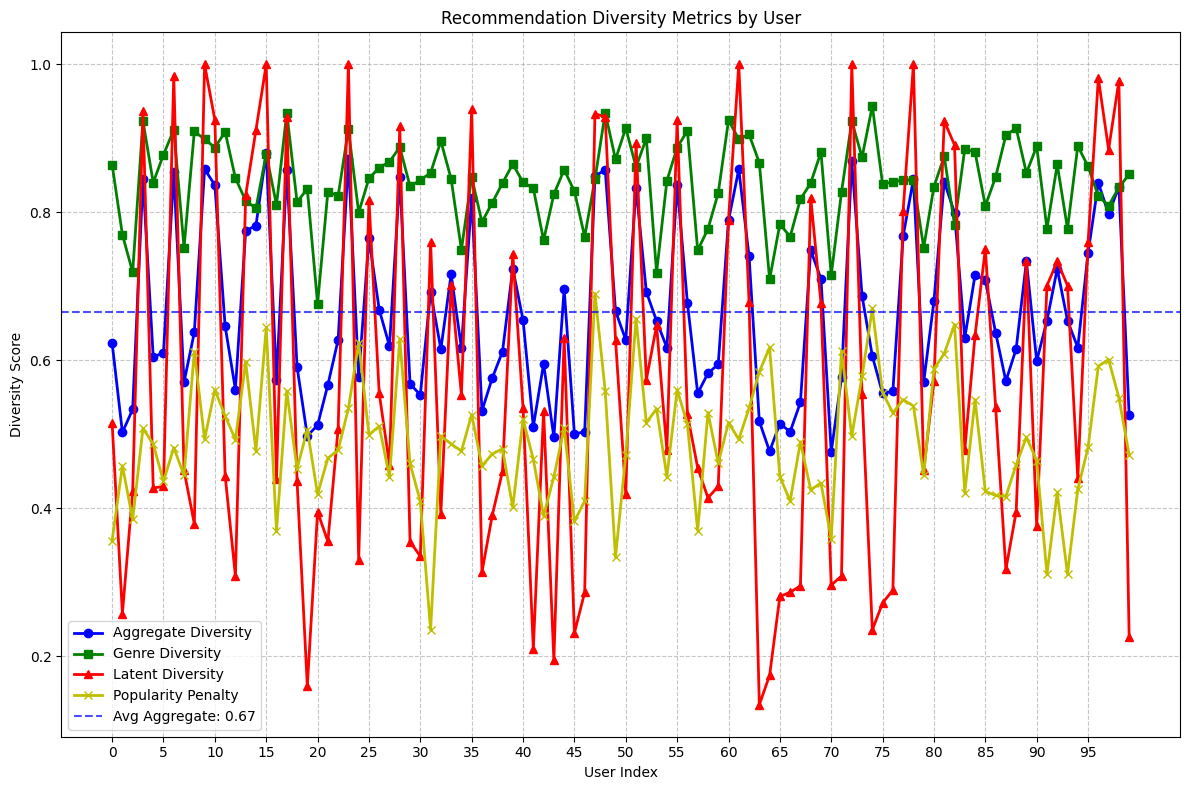

In [53]:
plot_diversity_scores(agg_score,genre_score,latent_score,penalty_score)

In [38]:
print(predictions[:5])

[{3017: [16498, 226, 1535, 4898, 227]}, {2665: [4181, 16498, 9989, 6547, 32]}, {3084: [4181, 5114, 2167, 9919, 6547]}, {783: [918, 9253, 11061, 19815, 4181]}, {2113: [30, 918, 9253, 2001, 2167]}]


Now, we implement a custom recommender

Step 1: create clusters for anime based on full metadata
consider one hot encoding genres first? 

Revise the data to prep for clustering

In [50]:
cluster_df = animes.copy()

# Handle missing or NaN values by replacing them with an empty string
cluster_df['genre'] = cluster_df['genre'].fillna('')

# Split the 'genre' column by commas and remove extra spaces
genre_list = cluster_df['genre'].str.split(',').apply(lambda x: [genre.strip() for genre in x])

# Get a list of all unique genres
all_genres = set([genre for sublist in genre_list for genre in sublist])

# Create one-hot encoding columns for each genre
for genre in all_genres:
    cluster_df[genre] = genre_list.apply(lambda genres: 1 if genre in genres else 0)


# Handle missing or NaN values in 'type' by replacing them with an empty string
cluster_df['type'] = cluster_df['type'].fillna('')

# Get a list of all unique types (no need to split, just unique values)
all_types = cluster_df['type'].unique()

# Create one-hot encoding columns for each type
for t in all_types:
    cluster_df[t] = (cluster_df['type'] == t).astype(int)

# Drop all categories that will interfere with clustering (strings with semantics)
cluster_df = cluster_df.drop(columns=['genre', 'type', 'name', 'anime_id']) # this is done assuming the entries don't get shuffled around during the soft-clustering algo


# cast episodes to numbers?
cluster_df['episodes'] = pd.to_numeric(cluster_df['episodes'], errors='coerce').fillna(0).astype(int)

#make all nan 0
cluster_df = cluster_df.fillna(0)

print(cluster_df.head())

   episodes  rating  members  Romance  Super Power     Shounen Ai  Yaoi  \
0         1    9.37   200630        1            0  0           0     0   
1        64    9.26   793665        0            0  0           0     0   
2        51    9.25   114262        0            0  0           0     0   
3        24    9.17   673572        0            0  0           0     0   
4        51    9.16   151266        0            0  0           0     0   

   Drama  Kids  ...  Fantasy  School  Sci-Fi  Shoujo  Harem  Movie  TV  OVA  \
0      1     0  ...        0       1       0       0      0      1   0    0   
1      1     0  ...        1       0       0       0      0      0   1    0   
2      0     0  ...        0       0       1       0      0      0   1    0   
3      0     0  ...        0       0       1       0      0      0   1    0   
4      0     0  ...        0       0       1       0      0      0   1    0   

   Special  ONA  
0        0    0  
1        0    0  
2        0    0  
3 

Now, the actual clustering

In [51]:
# Identify columns with non-numeric data types
non_numeric_columns = cluster_df.select_dtypes(exclude=['number']).columns

# Display the non-numeric columns
print(non_numeric_columns)


Index([], dtype='object')


In [52]:
from sklearn.preprocessing import MinMaxScaler
# scale data appropriately 
from sklearn.preprocessing import StandardScaler
import numpy as np

# Log-transform 'members' to reduce skewness
cluster_df['members'] = np.log1p(cluster_df['members'])

# # Initialize MinMaxScaler -> [0-1]
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaled_columns = ['episodes', 'rating', 'members']  
cluster_df[scaled_columns] = scaler.fit_transform(cluster_df[scaled_columns])


cluster_df[['rating', 'members']] *= 5  # Give more weight


# Keep binary (0/1) genre features unchanged


In [53]:
print(cluster_df.head())

   episodes     rating    members  Romance  Super Power     Shounen Ai  Yaoi  \
0 -0.238677  11.232573  10.303565        1            0  0           0     0   
1  1.123326  10.823062  13.265672        0            0  0           0     0   
2  0.842278  10.785833   9.090966        0            0  0           0     0   
3  0.258562  10.488007  12.912280        0            0  0           0     0   
4  0.842278  10.450779   9.695244        0            0  0           0     0   

   Drama  Kids  ...  Fantasy  School  Sci-Fi  Shoujo  Harem  Movie  TV  OVA  \
0      1     0  ...        0       1       0       0      0      1   0    0   
1      1     0  ...        1       0       0       0      0      0   1    0   
2      0     0  ...        0       0       1       0      0      0   1    0   
3      0     0  ...        0       0       1       0      0      0   1    0   
4      0     0  ...        0       0       1       0      0      0   1    0   

   Special  ONA  
0        0    0  
1       

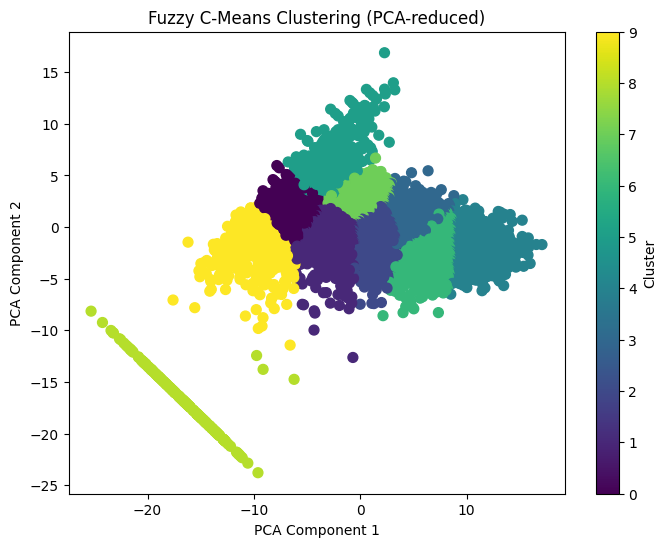

   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  cluster_0_membership  cluster_1_membership  cluster_2_membership  \
0   200630              0.004255              0.008561              0.023367   
1   793665              0.005666              0.011198          

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from fcmeans import FCM
from sklearn.decomposition import PCA

# Apply Fuzzy C-Means clustering
n_clusters = 10
fcm = FCM(n_clusters=n_clusters, m=1.5)  # Try lowering m (default is 2.0)
fcm.fit(cluster_df.values)

# Get the membership matrix
membership_matrix = fcm.u  # Shape: (n_samples, n_clusters)

# Convert membership matrix to DataFrame
membership_df = pd.DataFrame(membership_matrix, columns=[f'cluster_{i}_membership' for i in range(n_clusters)])

# Ensure index alignment before merging
membership_df.index = cluster_df.index  # Align indices before merging

# Merge membership scores into the original DataFrame
final_df = pd.concat([animes, membership_df], axis=1)

# Get the most dominant cluster for each anime
cluster_labels = membership_matrix.argmax(axis=1)

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_df.values)

# Scatter plot with colors based on cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title('Fuzzy C-Means Clustering (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Display the final DataFrame with anime info and clustering results
print(final_df.head())


Great! Okay, now we need to re-rank the SVD suggestions for a person based on the clusters